**Importing Libraries**

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
import torch
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn as nn
from sklearn.metrics import accuracy_score

In [81]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [82]:
df = pd.read_csv("../input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv")
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [83]:
df.shape

(162980, 2)

In [84]:
df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [85]:
df = df.dropna()

In [86]:
df.shape

(162969, 2)

In [87]:
df['category'] = df['category'].map({
    -1.0: "Negative",
    1.0: "Positive",
    0.0: "Neutral"
})

df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,Negative
1,talk all the nonsense and continue all the dra...,Neutral
2,what did just say vote for modi welcome bjp t...,Positive
3,asking his supporters prefix chowkidar their n...,Positive
4,answer who among these the most powerful world...,Positive


In [88]:
temp = df.groupby("category").count()

temp

,clean_text
category,
Negative,35509
Neutral,55211
Positive,72249


In [89]:
temp["clean_text"].values

array([35509, 55211, 72249])

<BarContainer object of 3 artists>

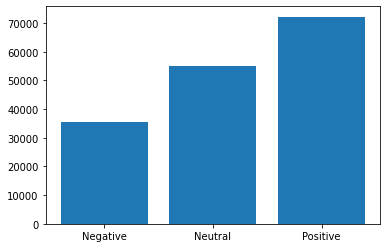

In [90]:
plt.bar(temp.index, temp["clean_text"].values)

In [91]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [92]:
def preprocessing(sentence):
  sentence = sentence.lower()
  sentence = re.sub(r"[^a-zA-Z0-9]", " ", sentence)
  words = word_tokenize(sentence)
  words = [stemmer.stem(word) for word in words if word not in stop_words]
#   words = [stemmer.stem(word) for word in words]
  return words

In [93]:
sentence = df['clean_text'][0]

sentence

'when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples'

In [94]:
preprocessing(sentence)

['modi',
 'promis',
 'minimum',
 'govern',
 'maximum',
 'govern',
 'expect',
 'begin',
 'difficult',
 'job',
 'reform',
 'state',
 'take',
 'year',
 'get',
 'justic',
 'state',
 'busi',
 'exit',
 'psu',
 'templ']

In [95]:
X = list(map(preprocessing, df['clean_text']))

X[0]

['modi',
 'promis',
 'minimum',
 'govern',
 'maximum',
 'govern',
 'expect',
 'begin',
 'difficult',
 'job',
 'reform',
 'state',
 'take',
 'year',
 'get',
 'justic',
 'state',
 'busi',
 'exit',
 'psu',
 'templ']

In [96]:
encoder = LabelEncoder()

Y = encoder.fit_transform(df["category"])

print(df["category"].values[:5], Y[:5])

['Negative' 'Neutral' 'Positive' 'Positive' 'Positive'] [0 1 2 2 2]


In [97]:
def label_encoding(X):
  vocab = set()
  for review in X:
    for word in review:
      vocab.add(word)

  counter = 1
  mapper = {}
  for word in vocab:
    mapper[word] = counter
    counter += 1

  return mapper 

In [98]:
mapper = label_encoding(X)

In [99]:
def apply_encoding(mapper, X):
  new_X = []
  for review in X:
    temp = []
    for word in review:
      temp.append(mapper[word])
    new_X.append(temp)

  return new_X

In [100]:
X = apply_encoding(mapper, X)

In [101]:
def max_len(X):
  maxi = 0
  for review in X:
    maxi = max(maxi, len(review))
  return maxi

max_len(X)

43

In [102]:
def list_tensor(X):
  new_X = []
  for review in X:
    new_X.append(torch.Tensor(review))

  return new_X

In [103]:
X_tensor = list_tensor(X)

X_tensor[0]

tensor([50278., 27857., 32333., 14399., 55129., 14399., 63842.,  7223., 14836.,
        82489., 86839., 73528., 58356., 70306., 83482., 22101., 73528., 35540.,
         9980., 52657., 36422.])

In [104]:
new_X = pad_sequence(X_tensor, batch_first=True)

In [105]:
new_X[0]

tensor([50278., 27857., 32333., 14399., 55129., 14399., 63842.,  7223., 14836.,
        82489., 86839., 73528., 58356., 70306., 83482., 22101., 73528., 35540.,
         9980., 52657., 36422.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.])

In [106]:
Y_array = np.array(Y)

In [107]:
X_array = np.array(new_X, dtype="int32")

In [108]:
X_array[0]

array([50278, 27857, 32333, 14399, 55129, 14399, 63842,  7223, 14836,
       82489, 86839, 73528, 58356, 70306, 83482, 22101, 73528, 35540,
        9980, 52657, 36422,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0], dtype=int32)

In [109]:
X_train, X_test, Y_train, Y_test = train_test_split(X_array, Y_array, test_size=0.2, random_state=0)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape 

((130375, 43), (130375,), (32594, 43), (32594,))

In [110]:
vocab_size = len(mapper)
vocab_size += 1

vocab_size

87935

In [111]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [112]:
print(device)

cuda


### LSTM

In [113]:
torch.cuda.empty_cache()

In [114]:
class LSTM(nn.Module):
  
  def __init__(self, vocab_size):
    super().__init__()
    self.hidden_size = 64
    self.embedding = nn.Embedding(vocab_size, 32)
    self.lstm = nn.LSTM(32, self.hidden_size, 1, batch_first=True,bidirectional=False) # 1 :- no. of layers
    self.linear = nn.Linear(self.hidden_size, 3)
    self.dropout = nn.Dropout(p=0.5)

  def forward(self, x):
    batch_size = x.shape[0]

    x_embedding = self.embedding(x)
    
    h0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
    
    out, hidden_state = self.lstm(x_embedding, (h0, c0))
    
    last_output = out[:, -1, :]
    
    last_out = self.dropout(last_output)
    
    final_output = self.linear(last_output)
    
    return final_output

In [115]:
def training(model, optimizer, loss_function, n_epochs, X, Y,X_test,Y_test):
  for epoch in range(n_epochs):

    batch_size = 128
    size = X.shape[0]

    for i in range(0, size, batch_size):
      
      start = i
      end = i + batch_size
      end = min(size, end)

      X_batch = X[start:end]
      Y_batch = Y[start:end]

      prediction = model.forward(X_batch)

      loss = loss_function(prediction, Y_batch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    if (epoch+1)%5==0:
        with torch.no_grad():
          prediction = model.forward(X)
          Y_pred = torch.argmax(prediction, dim=1)
          Y_pred_cpu = Y_pred.cpu().numpy()
          Y_actual_cpu = Y.cpu().numpy()
          print(f"Epoch {epoch+1}:- Accuracy: {accuracy_score(Y_actual_cpu, Y_pred_cpu)*100}")
          prediction = model.forward(X_test)
          Y_pred = torch.argmax(prediction, dim=1)
          Y_pred_cpu = Y_pred.cpu().numpy()
          Y_actual_cpu = Y_test.cpu().numpy()
          print(f"Testing Accuracy: {accuracy_score(Y_actual_cpu, Y_pred_cpu)*100}")

In [116]:
lstm_model = LSTM(vocab_size).to(device)

In [117]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.0001)

In [118]:
Y_tensor = torch.tensor(Y_train).to(device)

X_tensor = torch.tensor(X_train, dtype=torch.int32).to(device)
Y_test_tensor = torch.tensor(Y_test).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.int32).to(device)

training(lstm_model, optimizer, loss_function, 200, X_tensor, Y_tensor,X_test_tensor,Y_test_tensor)

Epoch 5:- Accuracy: 61.962032598274206
Testing Accuracy: 61.70767625943425
Epoch 10:- Accuracy: 67.42396931927134
Testing Accuracy: 66.7883659569246
Epoch 15:- Accuracy: 71.77603068072867
Testing Accuracy: 69.33177885500399
Epoch 20:- Accuracy: 75.25215723873441
Testing Accuracy: 71.70644903970056
Epoch 25:- Accuracy: 78.13767976989453
Testing Accuracy: 73.79885868564766
Epoch 30:- Accuracy: 80.11428571428571
Testing Accuracy: 75.1119838006995
Epoch 35:- Accuracy: 82.31409395973155
Testing Accuracy: 76.722709701172
Epoch 40:- Accuracy: 83.02205177372961
Testing Accuracy: 77.81186721482482
Epoch 45:- Accuracy: 84.89204218600192
Testing Accuracy: 78.17389703626434
Epoch 50:- Accuracy: 86.05714285714285
Testing Accuracy: 78.63410443639933
Epoch 55:- Accuracy: 87.29817833173537
Testing Accuracy: 79.09431183653433
Epoch 60:- Accuracy: 86.87938638542664
Testing Accuracy: 79.32748358593606
Epoch 65:- Accuracy: 89.01323106423777
Testing Accuracy: 79.46247775664233
Epoch 70:- Accuracy: 89.51792

**200 epochs lr = 0.0001**

**Training accuracy reached = 92%**

**Testing accuracy reached = 77%**